In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, HMC, NUTS, mcmc_kernel

from pyro.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings('ignore')

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [4]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

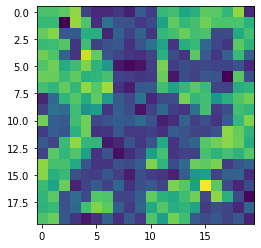

In [10]:
np.random.seed(1)
n = 10
l = 20
im = np.zeros((l, l))  # im lxl
points = l*np.random.random((3, n**2))

im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 20 # random noise
#plt.imshow(np.reshape(im, (256,256)))

im = ndimage.gaussian_filter(im, sigma=l/(2.*n))
plt.imshow(np.reshape(im, (l,l)))

mask = (im > im.mean()).astype(np.float)
img = mask*5 + 0.8*np.random.randn(*mask.shape)
plt.imshow(np.reshape(img, (l,l)))



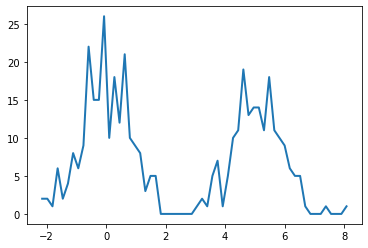

In [11]:
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)


In [12]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(0., 5.))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) 
        pyro.sample("obs", Normal(mu[z], 1.), obs=data)

    return beta,mu,z

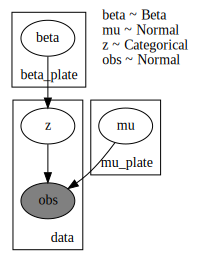

Warmup:   2%|▏         | 12/700 [00:20,  6.30it/s, step size=4.17e-02, acc. prob=0.710]

In [ ]:
T = 6
N = 400
alpha = 0.05

data = torch.reshape(torch.tensor(img), (-1,)).float()
N = data.shape[0]
pyro.render_model(model, model_args=(data,), render_distributions=True)

### DO NOT run again if not needed!
Load dictionary containing results instead

In [14]:
# pyro.clear_param_store()
# nuts_kernel = NUTS(model)
# mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=200, num_chains=1)
# mcmc.run(data=data)
# mcmc.summary()

Sample: 100%|██████████| 700/700 [04:00,  2.91it/s, step size=1.78e-01, acc. prob=0.840]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.55      0.02      0.55      0.51      0.58    273.94      0.99
   beta[1]      1.00      0.01      1.00      1.00      1.00    134.20      1.00
   beta[2]      0.95      0.14      1.00      0.82      1.00    213.99      0.99
   beta[3]      0.91      0.22      1.00      0.64      1.00    139.18      1.00
   beta[4]      0.90      0.22      1.00      0.61      1.00    185.55      1.00
     mu[0]     -0.01      0.06     -0.01     -0.10      0.11    191.71      1.00
     mu[1]      5.08      0.08      5.08      4.96      5.20    118.03      1.00
     mu[2]      0.70      5.36      0.65     -6.81     10.74    132.91      1.00
     mu[3]     -0.79      5.41     -0.51     -9.34      8.23    171.67      1.00
     mu[4]      0.49      5.54     -0.11     -9.29      8.59    138.56      1.00
     mu[5]      0.08      4.78      0.35     -8.36      7.27    156.54      1.00

Number of divergences: 0


In [22]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)

beta = mcmc_samples['beta'][0]
mu = mcmc_samples['mu'][0]
#sigma = mcmc_samples['sigma'][0]

In [28]:
# the following three lines are to save results to file
# f = open("results/mcmc_results.pkl", "wb")
# pickle.dump(mcmc_samples, f)
# f.close()

# the following is to load results from file
f = open("results/mcmc_results.pkl", "rb")
output = pickle.load(f)
print(output)
f.close()

# reassign mcmc_samples
mcmc_samples = output

{'beta': tensor([[[0.5573, 1.0000, 1.0000, 0.9780, 1.0000],
         [0.5567, 0.9824, 0.9524, 0.9785, 0.9436],
         [0.5269, 0.9985, 0.9999, 0.5833, 0.9954],
         [0.5600, 0.9993, 0.6038, 0.9966, 0.9636],
         [0.5126, 0.9969, 0.9864, 0.2301, 0.6660],
         [0.5642, 1.0000, 0.9979, 1.0000, 0.9993],
         [0.5740, 0.9743, 1.0000, 0.9998, 0.8933],
         [0.5372, 1.0000, 1.0000, 0.9999, 0.9493],
         [0.5551, 0.9763, 0.9993, 1.0000, 1.0000],
         [0.5378, 0.9915, 0.9991, 0.9995, 1.0000],
         [0.5469, 1.0000, 0.9315, 0.9922, 1.0000],
         [0.5503, 1.0000, 0.9887, 0.9982, 1.0000],
         [0.5157, 1.0000, 0.9906, 0.9894, 0.9986],
         [0.5922, 1.0000, 0.9497, 1.0000, 1.0000],
         [0.5737, 0.9998, 0.9425, 0.9999, 0.9999],
         [0.5015, 0.9999, 0.9970, 1.0000, 0.9999],
         [0.5006, 1.0000, 0.9979, 1.0000, 0.9998],
         [0.5231, 1.0000, 0.9906, 1.0000, 1.0000],
         [0.5237, 0.9840, 0.9965, 1.0000, 0.9998],
         [0.5611, 1.00

torch.Size([1, 200, 6])


<AxesSubplot:ylabel='Density'>

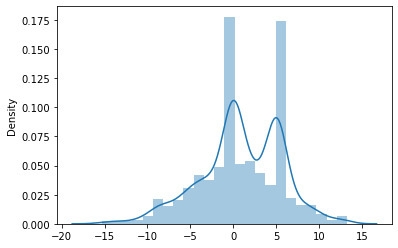

In [29]:
import seaborn as sns

print(mcmc_samples['mu'].shape)
sns.distplot(mcmc_samples["mu"])

In [30]:
from scipy.stats import norm 

w = mix_weights(beta)[-1]
n_samples = mu.shape[0]
n = data.shape[0]
cluster = np.zeros(n)

for i in range(n):
    q = torch.zeros(T)
    for j in range(T):
        q[j] = w[j]*norm.pdf(data[i], mu[-1][j], 1.) + q[j]

    cluster[i] = np.argmax(q)

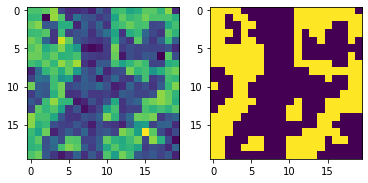

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122) 

ax1.imshow( np.reshape(data, (20,20)))
ax2.imshow( np.reshape(cluster, (20,20)))


### How many clusters are found?

In [34]:
print("number of clusters found: ", len(np.unique(cluster)))

number of clusters found:  2
